In [1]:
FN = 'train'

you should use GPU but if it is busy then you always can fall back to your CPU

In [2]:
import os
os.environ['THEANO_FLAGS'] = 'device=cpu,floatX=float32'

In [3]:
import keras
keras.__version__

Using TensorFlow backend.


'2.0.6'

Use indexing of tokens from [vocabulary-embedding](./vocabulary-embedding.ipynb) this does not clip the indexes of the words to `vocab_size`.

Use the index of outside words to replace them with several `oov` words (`oov` , `oov0`, `oov1`, ...) that appear in the same description and headline. This will allow headline generator to replace the oov with the same word in the description

In [4]:
FN0 = 'vocabulary-embedding'

implement the "simple" model from http://arxiv.org/pdf/1512.01712v1.pdf

you can start training from a pre-existing model. This allows you to run this notebooks many times, each time using different parameters and passing the end result of one run to be the input of the next.

I've started with `maxlend=0` (see below) in which the description was ignored. I then moved to start with a high `LR` and the manually lowering it. I also started with `nflips=0` in which the original headlines is used as-is and slowely moved to `12` in which half the input headline was fliped with the predictions made by the model (the paper used fixed 10%)

In [5]:
FN1 = 'train'

input data (`X`) is made from `maxlend` description words followed by `eos`
followed by headline words followed by `eos`
if description is shorter than `maxlend` it will be left padded with `empty`
if entire data is longer than `maxlen` it will be clipped and if it is shorter it will be right padded with empty.

labels (`Y`) are the headline words followed by `eos` and clipped or padded to `maxlenh`

In other words the input is made from a `maxlend` half in which the description is padded from the left
and a `maxlenh` half in which `eos` is followed by a headline followed by another `eos` if there is enough space.

The labels match only the second half and 
the first label matches the `eos` at the start of the second half (following the description in the first half)

In [6]:
maxlend=50 # 0 - if we dont want to use description at all
maxlenh=50
maxlen = maxlend + maxlenh
rnn_size = 512 # must be same as 160330-word-gen
rnn_layers = 3  # match FN1
batch_norm=False

the out of the first `activation_rnn_size` nodes from the top LSTM layer will be used for activation and the rest will be used to select predicted word

In [7]:
activation_rnn_size = 40 if maxlend else 0

In [8]:
# training parameters
seed=42
p_W, p_U, p_dense, weight_decay = 0, 0, 0, 0
optimizer = 'adam'
LR = 1e-4
batch_size=64
nflips=10

In [9]:
nb_train_samples = 160
nb_val_samples = 70

# read word embedding

In [10]:
import pickle

with open('data/%s.pkl'%FN0, 'rb') as fp:
    embedding, idx2word, word2idx, glove_idx2idx = pickle.load(fp)
vocab_size, embedding_size = embedding.shape

In [11]:
embedding.shape

(36723, 100)

In [12]:
with open('data/%s.data.pkl'%FN0, 'rb') as fp:
    X, Y = pickle.load(fp)

In [13]:
#maxlend = max([len(x) for x in X])
#maxlenh = max([len(y) for y in Y])
#maxlend, maxlenh

In [14]:
nb_unknown_words = 10

In [15]:
print ('number of examples',len(X),len(Y))
print ('dimension of embedding space for words',embedding_size)
print ('vocabulary size', vocab_size, 'the last %d words can be used as place holders for unknown/oov words'%nb_unknown_words)
print ('total number of different words',len(idx2word), len(word2idx))
print ('number of words outside vocabulary which we can substitue using glove similarity', len(glove_idx2idx))
print ('number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov)',len(idx2word)-vocab_size-len(glove_idx2idx))

number of examples 281 281
dimension of embedding space for words 100
vocabulary size 36723 the last 10 words can be used as place holders for unknown/oov words
total number of different words 36724 36724
number of words outside vocabulary which we can substitue using glove similarity 47
number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov) -46


In [16]:
for i in range(nb_unknown_words):
    idx2word[vocab_size-1-i] = '<%d>'%i

when printing mark words outside vocabulary with `^` at their end

In [17]:
oov0 = vocab_size-nb_unknown_words

In [18]:
for i in range(oov0, len(idx2word)):
    idx2word[i] = idx2word[i]+'^'

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=nb_val_samples, random_state=seed)
len(X_train), len(Y_train), len(X_test), len(Y_test)

(211, 211, 70, 70)

In [20]:
del X
del Y

In [21]:
empty = 0
eos = 1
idx2word[empty] = '_'
idx2word[eos] = '~'

In [22]:
import numpy as np
from keras.preprocessing import sequence
from keras.utils import np_utils
import random, sys

In [23]:
def prt(label, x):
    print (label+':', end=" ")
    print("\n")
    for w in x:
        print (idx2word[w], end=" ")
    print("\n")

In [24]:
i = 160
prt('H',Y_train[i])
prt('D',X_train[i])

H: 

Lyft to unleash self-driving cars on Bay Area roads 

D: 

SAN FRANCISCO — Self-driving Lyfts are coming to the Bay Area, promising to give local residents a first-hand look at the technology that’s poised to dramatically change the nature of transportation. Lyft will launch a pilot fleet of self-driving cars to pick up local passengers, the San Francisco-based ride-hailing company said Thursday, though it didn’t reveal an exact start date. The announcement comes as Lyft is accelerating its efforts to dominate the self-driving car market and compete with the likes of Uber, Google and Tesla — Lyft recently opened a new autonomous vehicle hub in Palo Alto and earlier this summer announced plans to bring self-driving cars to Boston. Now Lyft plans to unleash autonomous vehicles on busy Bay Area roads, where they will have to interact with local drivers, bicyclists and pedestrians, representing a crucial test of the technology. Lyft has teamed up with another startup — Drive.ai — whic

In [25]:
i = 50
prt('H',Y_test[i])
prt('D',X_test[i])

H: 

Rust application that converts C++ libraries to single self-contained headers 

D: 

This is my first Rust project, mainly created to start getting used to the language. My intention is to improve as I get better with Rust and the final goal is being able to successfully use it on popular libraries. I also do not encourage people to create single-header libraries and use those in their projects: they're mainly useful when dealing with very complicated build systems or when experimenting on an online compiler that doesn't allow users to easily import multiple files. Contributions and code reviews are welcome! Given a set of paths containing the C++ library's header files and a "top-level include" file where the graph traversal will start from, outputs a self-contained single-header version of the library to . Here's the auto-generated help: is currently able to transform , my latest C++17 header-only library, to a single-header version. In fact, I've used to add two badges to 's RE

# Model

In [26]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.regularizers import l2

In [27]:
# seed weight initialization
random.seed(seed)
np.random.seed(seed)

In [28]:
regularizer = l2(weight_decay) if weight_decay else None

In [29]:
embedding

array([[-0.01773875,  0.06372642,  0.03280158, ..., -0.01024496,
        -0.06710091, -0.05544016],
       [-0.06625115,  0.01928704, -0.02624818, ...,  0.05614735,
         0.05473008,  0.03957156],
       [-0.0038194 , -0.024487  ,  0.072812  , ..., -0.01459   ,
         0.08278   ,  0.027062  ],
       ..., 
       [-0.076047  , -0.060407  ,  0.029848  , ...,  0.024915  ,
         0.084378  , -0.01159   ],
       [-0.05896605,  0.06575593,  0.04508276, ...,  0.04003331,
        -0.01954881, -0.04167179],
       [-0.0213262 ,  0.00867258, -0.01099002, ...,  0.03958262,
        -0.00101131,  0.01165937]])

start with a standaed stacked LSTM

In [30]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size,
                    input_length=maxlen,
                    embeddings_regularizer=regularizer, weights=[embedding], mask_zero=True,
                    name='embedding_1'))

for i in range(rnn_layers):
    lstm = LSTM(rnn_size, return_sequences=True, # batch_norm=batch_norm,
                kernel_regularizer=regularizer, recurrent_regularizer=regularizer,
                bias_regularizer=regularizer, dropout=p_W, recurrent_dropout=p_U,
                name='lstm_%d'%(i+1)
                  )
    model.add(lstm)
    model.add(Dropout(p_dense,name='dropout_%d'%(i+1)))

A special layer that reduces the input just to its headline part (second half).
For each word in this part it concatenate the output of the previous layer (RNN)
with a weighted average of the outputs of the description part.
In this only the last `rnn_size - activation_rnn_size` are used from each output.
The first `activation_rnn_size` output is used to computer the weights for the averaging.

In [31]:
from keras.layers.core import Lambda
import keras.backend as K

def simple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:,:maxlend,:], X[:,maxlend:,:]
    head_activations, head_words = head[:,:,:n], head[:,:,n:]
    desc_activations, desc_words = desc[:,:,:n], desc[:,:,n:]
    
    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=(2,2))
    # make sure we dont use description words that are masked out
    activation_energies = activation_energies + -1e20*K.expand_dims(1.-K.cast(mask[:, :maxlend],'float32'),1)
    
    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies,(-1,maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights,(-1,maxlenh,maxlend))

    # for every head word compute weighted average of desc words
    desc_avg_word = K.batch_dot(activation_weights, desc_words, axes=(2,1))
    return K.concatenate((desc_avg_word, head_words))

In [32]:
if activation_rnn_size:
    model.add(Lambda(simple_context,
                     mask = lambda inputs, mask: mask[:,maxlend:],
                     output_shape = lambda input_shape: (input_shape[0], maxlenh, 2*(rnn_size - activation_rnn_size)),
                     name='simplecontext_1'))
model.add(TimeDistributed(Dense(vocab_size,
                                kernel_regularizer=regularizer, bias_regularizer=regularizer,
                                name = 'timedistributed_1')))
model.add(Activation('softmax', name='activation_1'))

In [33]:
from keras.optimizers import Adam, RMSprop # usually I prefer Adam but article used rmsprop
# opt = Adam(lr=LR)  # keep calm and reduce learning rate
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [34]:
K.set_value(model.optimizer.lr,np.float32(LR))

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          3672300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 512)          1255424   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 512)          2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 512)          2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 512)          0         
__________

# Load

In [36]:
if FN1:
    model.load_weights('data/%s.hdf5'%FN1)

# Test

In [37]:
def lpadd(x, maxlend=maxlend, eos=eos):
    """left (pre) pad a description to maxlend and then add eos.
    The eos is the input to predicting the first word in the headline
    """
    assert maxlend >= 0
    if maxlend == 0:
        return [eos]
    n = len(x)
    if n > maxlend:
        x = x[-maxlend:]
        n = maxlend
    return [empty]*(maxlend-n) + x + [eos]

In [38]:
samples = [lpadd([3]*26)]
# pad from right (post) so the first maxlend will be description followed by headline
data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')

In [39]:
np.all(data[:,maxlend] == eos)

True

In [40]:
data.shape,map(len, samples)

((1, 100), <map at 0x109a17da0>)

In [41]:
probs = model.predict(data, verbose=0, batch_size=1)
probs.shape

(1, 50, 36723)

# Sample generation

this section is only used to generate examples. you can skip it if you just want to understand how the training works

In [42]:
# variation to https://github.com/ryankiros/skip-thoughts/blob/master/decoding/search.py
def beamsearch(predict, start=[empty]*maxlend + [eos],
               k=1, maxsample=maxlen, use_unk=True, empty=empty, eos=eos, temperature=1.0):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    def sample(energy, n, temperature=temperature):
        """sample at most n elements according to their energy"""
        n = min(n,len(energy))
        prb = np.exp(-np.array(energy) / temperature )
        res = []
        for i in range(n):
            z = np.sum(prb)
            r = np.argmax(np.random.multinomial(1, prb/z, 1))
            res.append(r)
            prb[r] = 0. # make sure we select each element only once
        return res

    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [list(start)]
    live_scores = [0]

    while live_k:
        # for every possible live sample calc prob for every possible label 
        probs = predict(live_samples, empty=empty)

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        cand_scores[:,empty] = 1e20
        if not use_unk:
            for i in range(nb_unknown_words):
                cand_scores[:,vocab_size - 1 - i] = 1e20
        live_scores = list(cand_scores.flatten())
        

        # find the best (lowest) scores we have from all possible dead samples and
        # all live samples and all possible new words added
        scores = dead_scores + live_scores
        ranks = sample(scores, k)
        n = len(dead_scores)
        ranks_dead = [r for r in ranks if r < n]
        ranks_live = [r - n for r in ranks if r >= n]
        
        dead_scores = [dead_scores[r] for r in ranks_dead]
        dead_samples = [dead_samples[r] for r in ranks_dead]
        
        live_scores = [live_scores[r] for r in ranks_live]

        # append the new words to their appropriate live sample
        voc_size = probs.shape[1]
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_live]

        # live samples that should be dead are...
        # even if len(live_samples) == maxsample we dont want it dead because we want one
        # last prediction out of it to reach a headline of maxlenh
        zombie = [s[-1] == eos or len(s) > maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    return dead_samples + live_samples, dead_scores + live_scores

In [43]:
# !pip install python-Levenshtein

In [44]:
def keras_rnn_predict(samples, empty=empty, model=model, maxlen=maxlen):
    """for every sample, calculate probability for every possible label
    you need to supply your RNN model and maxlen - the length of sequences it can handle
    """
    sample_lengths = list(map(len, samples))
    assert all(l > maxlend for l in sample_lengths)
    assert all(l[maxlend] == eos for l in samples)
    # pad from right (post) so the first maxlend will be description followed by headline
    data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')
    probs = model.predict(data, verbose=0, batch_size=batch_size)
    return np.array([prob[sample_length-maxlend-1] for prob, sample_length in zip(probs, sample_lengths)])

In [45]:
def vocab_fold(xs):
    """convert list of word indexes that may contain words outside vocab_size to words inside.
    If a word is outside, try first to use glove_idx2idx to find a similar word inside.
    If none exist then replace all accurancies of the same unknown word with <0>, <1>, ...
    """
    xs = [x if x < oov0 else glove_idx2idx.get(x,x) for x in xs]
    # the more popular word is <0> and so on
    outside = sorted([x for x in xs if x >= oov0])
    # if there are more than nb_unknown_words oov words then put them all in nb_unknown_words-1
    outside = dict((x,vocab_size-1-min(i, nb_unknown_words-1)) for i, x in enumerate(outside))
    xs = [outside.get(x,x) for x in xs]
    return xs


In [46]:
def vocab_unfold(desc,xs):
    # assume desc is the unfolded version of the start of xs
    unfold = {}
    for i, unfold_idx in enumerate(desc):
        fold_idx = xs[i]
        if fold_idx >= oov0:
            unfold[fold_idx] = unfold_idx
    return [unfold.get(x,x) for x in xs]

In [47]:
type(keras_rnn_predict)

function

In [48]:
import sys
import Levenshtein

def gensamples(skips=2, k=10, batch_size=batch_size, short=True, temperature=1., use_unk=True):
    i = random.randint(0,len(X_test)-1)
    print ('HEAD:',' '.join(idx2word[w] for w in Y_test[i][:maxlenh]))
    print ('DESC:',' '.join(idx2word[w] for w in X_test[i][:maxlend]))
    sys.stdout.flush()

    print ('HEADS:')
    x = X_test[i]
    samples = []

    if maxlend == 0:
        skips = [0]
    else:
        skips = range(min(maxlend,len(x)), max(maxlend,len(x)), abs(maxlend - len(x)) // skips + 1)
    for s in skips:
        start = lpadd(x[:s])
        fold_start = vocab_fold(start)
        sample, score = beamsearch(predict=keras_rnn_predict, start=fold_start, k=k, temperature=temperature, use_unk=use_unk)
        assert all(s[maxlend] == eos for s in sample)
        samples += [(s,start,scr) for s,scr in zip(sample,score)]

    samples.sort(key=lambda x: x[-1])
    codes = []
    for sample, start, score in samples:
        code = ''
        words = []
        sample = vocab_unfold(start, sample)[len(start):]
        for w in sample:
            if w == eos:
                break
            words.append(idx2word[w])
            code += chr(w//(256*256)) + chr((w//256)%256) + chr(w%256)
        if short:
            distance = min([100] + [-Levenshtein.jaro(code,c) for c in codes])
            if distance > -0.6:
                print (score, ' '.join(words))
        #         print '%s (%.2f) %f'%(' '.join(words), score, distance)
        else:
                print (score, ' '.join(words))
        codes.append(code)

In [49]:
gensamples(skips=2, batch_size=batch_size, k=10, temperature=1.)

HEAD: How a bullet turns into a beep
DESC: That last character is U+2022. Select that line with the mouse, right-click, and select Copy to copy it to the clipboard. Now go to a command prompt and paste it and hit Enter. You'd expect a • to be printed, but instead you get a beep. What happened? Hm, there's
HEADS:
2.25725698471 
5.799254179 of


In [50]:
# Data generator

Data generator generates batches of inputs and outputs/labels for training. The inputs are each made from two parts. The first maxlend words are the original description, followed by `eos` followed by the headline which we want to predict, except for the last word in the headline which is always `eos` and then `empty` padding until `maxlen` words.

For each, input, the output is the headline words (without the start `eos` but with the ending `eos`) padded with `empty` words up to `maxlenh` words. The output is also expanded to be y-hot encoding of each word.

To be more realistic, the second part of the input should be the result of generation and not the original headline.
Instead we will flip just `nflips` words to be from the generator, but even this is too hard and instead
implement flipping in a naive way (which consumes less time.) Using the full input (description + eos + headline) generate predictions for outputs. For nflips random words from the output, replace the original word with the word with highest probability from the prediction.

In [51]:
def flip_headline(x, nflips=None, model=None, debug=False):
    """given a vectorized input (after `pad_sequences`) flip some of the words in the second half (headline)
    with words predicted by the model
    """
    if nflips is None or model is None or nflips <= 0:
        return x
    
    batch_size = len(x)
    assert np.all(x[:,maxlend] == eos)
    probs = model.predict(x, verbose=0, batch_size=batch_size)
    x_out = x.copy()
    for b in range(batch_size):
        # pick locations we want to flip
        # 0...maxlend-1 are descriptions and should be fixed
        # maxlend is eos and should be fixed
        flips = sorted(random.sample(range(maxlend+1,maxlen), nflips))
        if debug and b < debug:
            print (b,)
        for input_idx in flips:
            if x[b,input_idx] == empty or x[b,input_idx] == eos:
                continue
            # convert from input location to label location
            # the output at maxlend (when input is eos) is feed as input at maxlend+1
            label_idx = input_idx - (maxlend+1)
            prob = probs[b, label_idx]
            w = prob.argmax()
            if w == empty:  # replace accidental empty with oov
                w = oov0
            if debug and b < debug:
                print ('%s => %s'%(idx2word[x_out[b,input_idx]],idx2word[w]),)
            x_out[b,input_idx] = w
        if debug and b < debug:
            print
    return x_out

In [52]:
def conv_seq_labels(xds, xhs, nflips=None, model=None, debug=False):
    """description and hedlines are converted to padded input vectors. headlines are one-hot to label"""
    batch_size = len(xhs)
    assert len(xds) == batch_size
    x = [vocab_fold(lpadd(xd)+xh) for xd,xh in zip(xds,xhs)]  # the input does not have 2nd eos
    x = sequence.pad_sequences(x, maxlen=maxlen, value=empty, padding='post', truncating='post')
    x = flip_headline(x, nflips=nflips, model=model, debug=debug)
    
    y = np.zeros((batch_size, maxlenh, vocab_size))
    for i, xh in enumerate(xhs):
        xh = vocab_fold(xh) + [eos] + [empty]*maxlenh  # output does have a eos at end
        xh = xh[:maxlenh]
        y[i,:,:] = np_utils.to_categorical(xh, vocab_size)
        
    return x, y

In [53]:
def gen(Xd, Xh, batch_size=batch_size, nb_batches=None, nflips=None, model=None, debug=False, seed=seed):
    """yield batches. for training use nb_batches=None
    for validation generate deterministic results repeating every nb_batches
    
    while training it is good idea to flip once in a while the values of the headlines from the
    value taken from Xh to value generated by the model.
    """
    c = nb_batches if nb_batches else 0
    while True:
        xds = []
        xhs = []
        if nb_batches and c >= nb_batches:
            c = 0
        new_seed = random.randint(0, sys.maxsize)
        random.seed(c+123456789+seed)
        for b in range(batch_size):
            t = random.randint(0,len(Xd)-1)

            xd = Xd[t]
            s = random.randint(min(maxlend,len(xd)), max(maxlend,len(xd)))
            xds.append(xd[:s])
            
            xh = Xh[t]
            s = random.randint(min(maxlenh,len(xh)), max(maxlenh,len(xh)))
            xhs.append(xh[:s])

        # undo the seeding before we yield inorder not to affect the caller
        c+= 1
        random.seed(new_seed)

        yield conv_seq_labels(xds, xhs, nflips=nflips, model=model, debug=debug)

In [54]:
r = next(gen(X_train, Y_train, batch_size=batch_size))
r[0].shape, r[1].shape, len(r)

((64, 100), (64, 50, 36723), 2)

In [55]:
def test_gen(gen, n=5):
    Xtr,Ytr = next(gen)
    for i in range(n):
        assert Xtr[i,maxlend] == eos
        x = Xtr[i,:maxlend]
        y = Xtr[i,maxlend:]
        yy = Ytr[i,:]
        yy = np.where(yy)[1]
        prt('L',yy)
        prt('H',y)
        if maxlend:
            prt('D',x)

In [56]:
test_gen(gen(X_train, Y_train, batch_size=batch_size))

L: 

Why people think Germans are so efficient ~ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

H: 

~ Why people think Germans are so efficient _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

D: 

Germany’s latest folly to their itinerary. According to Joseph Pearson, however, who explores German idiosyncrasies on his blog The Needle and in his upcoming book Berlin, the delayed airport shouldn’t be critiqued but celebrated precisely because it contradicts the long-held <0>^ a sign of history repetition its course. When things 

L: 

On Hiding a Plaintext Length by Preencryption (2011) [pdf] ~ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

H: 

~ On Hiding a Plaintext Length by Preencryption (2011) [pdf] _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

D: 

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

test fliping

In [57]:
test_gen(gen(X_train, Y_train, nflips=6, model=model, debug=False, batch_size=batch_size))


L: 

Why people think Germans are so efficient ~ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

H: 

~ Why people ~ Germans are so efficient _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

D: 

Germany’s latest folly to their itinerary. According to Joseph Pearson, however, who explores German idiosyncrasies on his blog The Needle and in his upcoming book Berlin, the delayed airport shouldn’t be critiqued but celebrated precisely because it contradicts the long-held <0>^ a sign of history repetition its course. When things 

L: 

On Hiding a Plaintext Length by Preencryption (2011) [pdf] ~ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

H: 

~ On Hiding ~ Plaintext Length by Preencryption (2011) [pdf] _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

D: 

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

In [58]:
valgen = gen(X_test, Y_test,nb_batches=3, batch_size=batch_size)

check that valgen repeats itself after nb_batches

In [59]:
for i in range(4):
    test_gen(valgen, n=1)

L: 

Understanding Moscow: The Mysteries of the Russian Mindset ~ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

H: 

~ Understanding Moscow: The Mysteries of the Russian Mindset _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

D: 

is not something that Russian politicians tend to consider. The debate about the resettlement of those living in the apartment buildings shows yet again that there is still no feedback loop in the Russian political system. The government doesn't make any serious effort to include the people in its decision-making. 

L: 

Unpopular Opinion: Peak Outrage ~ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

H: 

~ Unpopular Opinion: Peak Outrage _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

D: 

notified users via e-mail and as you access the app that the new TOS will affect them and that they need to ac

# Train

In [60]:
history = {}

In [61]:
traingen = gen(X_train, Y_train, batch_size=batch_size, nflips=nflips, model=model)
valgen = gen(X_test, Y_test, nb_batches=nb_val_samples//batch_size, batch_size=batch_size)

In [62]:
r = next(traingen)
r[0].shape, r[1].shape, len(r)

((64, 100), (64, 50, 36723), 2)

In [63]:
for iteration in range(30):
    print ('Iteration', iteration)
    h = model.fit_generator(traingen, steps_per_epoch=nb_train_samples//batch_size,
                        epochs=1, validation_data=valgen, validation_steps=nb_val_samples
                           )
    for k,v in h.history.items():
        history[k] = history.get(k,[]) + v
    with open('data/%s.history.pkl'%FN,'wb') as fp:
        pickle.dump(history,fp,-1)
    model.save_weights('data/%s.hdf5'%FN, overwrite=True)
    gensamples(batch_size=batch_size)

Iteration 0
Epoch 1/1
2/2 [==============================] - 693s - loss: 5.9540 - val_loss: 10.8047
HEAD: Introducing Pytorch for fast.ai
DESC: The next fast.ai courses will be based nearly entirely on a new framework we have developed, built on Pytorch. Pytorch is a different kind of deep learning library (dynamic, rather than static), which has been adopted by many (if not most) of the researchers that we most respect, and in
HEADS:
2.08736634254 
5.70818185806 of
Iteration 1
Epoch 1/1
2/2 [==============================] - 695s - loss: 6.1029 - val_loss: 10.8107
HEAD: Unpopular Opinion: Peak Outrage
DESC: On 2 October 2017 Twitter will have new Terms of Service (TOS) for users outside the United States of America. This, obviously, also affects Twitter users in Afrika. Twitter notified users via e-mail and as you access the app that the new TOS will affect them and that they need
HEADS:
2.12535810471 
5.96489524841 the
Iteration 2
Epoch 1/1
2/2 [==============================] - 686

HEADS:
2.1949634552 
6.03046917915 of
Iteration 17
Epoch 1/1
2/2 [==============================] - 720s - loss: 6.0299 - val_loss: 10.8496
HEAD: Cost of Push Notifications for Smartphones Using Tor Hidden Services
DESC: Some users are experiencing issues with previewing PDFs. We are working on a solution.For more information, see our Resources and Help FAQs
HEADS:
2.22980284691 
6.26112651825 to
Iteration 18
Epoch 1/1
2/2 [==============================] - 668s - loss: 6.0953 - val_loss: 10.8544
HEAD: Facebook will spend as much as $1B on original TV in the next year
DESC: The Wall Street Journal reports that Facebook is going into the next year “willing to spend as much as $1 billion” on original video content, building out the roster of exclusive TV on its revamped video tab Watch. In June, the WSJ reported that Facebook was willing to pay up
HEADS:
2.25321888924 
6.66653728485 a
Iteration 19
Epoch 1/1
2/2 [==============================] - 699s - loss: 6.0157 - val_loss: 10.8564
HE

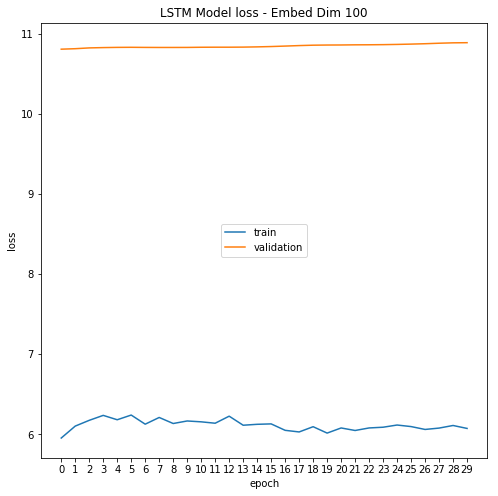

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

losses = [5.954,6.1029,6.1748,6.2366,6.182,6.2406,6.1268,6.2105,6.1352,6.1668,6.1561,6.1387,6.2267,6.1137,6.1252,6.1304,6.0502,6.0299,6.0953,6.0157,6.0796,6.0481,6.0798,6.0889,6.1162,6.0969,6.0611,6.0781,6.1105,6.0738]
val_losses = [10.8047,10.8107,10.8206,10.8245,10.8271,10.8281,10.8268,10.8261,10.8262,10.8266,10.8287,10.8294,10.8294,10.8305,10.8334,10.8376,10.8434,10.8496,10.8544,10.8564,10.8571,10.859,10.8597,10.8613,10.8641,10.868,10.8728,10.879,10.8839,10.8857]

plt.figure(figsize=(8, 8))               
plt.plot(losses)
plt.plot(val_losses)
plt.title('LSTM Model loss - Embed Dim 100')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(30))
plt.legend(['train', 'validation'], loc='center')
plt.show() 